# **EXPLORATORY DATA ANALYSIS ON TTC STATIONS**
This is the third part of my TTC Subway Delay project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import textwrap
import calendar
import requests
import json
import io
import geopandas as gpd
from shapely.geometry import shape, Point

In [2]:
df_master = pd.read_excel('Excel Files/df_master.xlsx')
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean,line_clean,datetime,time_period,delay_cause,delay_category
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,Sheppard-Yonge,Lines 1 and 4 Shared,2024-01-01 02:00:00,early_morning,Injured or ill Customer (On Train) - Transported,Passenger Related
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,Dundas,Line 1 Yonge-University,2024-01-01 02:00:00,early_morning,Injured or ill Customer (In Station) - Transpo...,Passenger Related
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,Dundas,Line 1 Yonge-University,2024-01-01 02:08:00,early_morning,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,Kennedy,Lines 2 and 3 Shared,2024-01-01 02:13:00,early_morning,Debris At Track Level - Uncontrollable,Fortuitous Event
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,Bloor-Yonge,Lines 1 and 2 Shared,2024-01-01 02:22:00,early_morning,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214456,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 19:50:00,evening,Miscellaneous Other,Undefined
214457,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107,Warden,Line 2 Bloor-Danforth,2017-04-30 20:25:00,evening,Disorderly Patron,Passenger Related
214458,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0,Keele,Line 2 Bloor-Danforth,2017-04-30 20:29:00,evening,Robbery,Passenger Related
214459,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 22:00:00,evening,Miscellaneous Other,Undefined


# Map Data Extraction and Cleaning

Here, we'll conduct EDA on the stations and check for any patterns or trends. We'll be importing map data from an arcgis database accessible through a url, so we can plot our data in a map that will look like the TTC subway. We can also do an EDA using the typical charts such as bar or line, but I want to make things visually interesting for the spatial data we have for this part of our EDA.

In [3]:
url = "https://gis.toronto.ca/arcgis/rest/services/cot_geospatial7/FeatureServer/8/query?where=1%3D1&outFields=*&outSR=4326&f=geojson"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses
geojson_data = json.loads(response.text)

# Convert the GeoJSON data to a GeoDataFrame
ttc_map = gpd.GeoDataFrame.from_features(geojson_data["features"])
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_KISS_RIDE,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2
0,POINT (-79.39835 43.70534),11272589,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None
1,POINT (-79.39712 43.69785),7273830,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None
2,POINT (-79.39298 43.68811),14076438,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001,...,No,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None
3,POINT (-79.39079 43.68229),8681089,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001,...,No,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None
4,POINT (-79.38875 43.67694),788874,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001,...,No,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,POINT (-79.41309 43.76901),14076455,5152,Yonge St,5152 Yonge St,None,North York,Toronto,None,115001,...,No,Train Platform to Mezzanine,No,"97,B,C Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/North_York_C...,None,None
69,POINT (-79.41236 43.7617),13967653,20,Sheppard Ave W,20 Sheppard Ave W,M2N 7H9,North York,Toronto,None,115001,...,No,Train Platform to Mezzanine and Bus Platform,Yes,"97,B,C Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard-Yon...,None,None
70,POINT (-79.40636 43.7449),12036646,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001,...,No,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None
71,POINT (-79.40193 43.72535),7762894,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001,...,No,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None


Looking at the above extracted geographic data set from arcgis, we can see two (2) concerns:
1. There's no explicit column for the station name. We can, however, extract this from the 'PT_WEBSITE' column; and
2. Two (2) stations are missing from the data set: Vaughan Metropolitan Centre and Highway 407. We'll try to append these two to the data set above. The important features we need are 'LONGITUDE', 'LATITUDE', and the station name.

Let's work on extracting the station name first.

In [4]:
ttc_map['station_clean'] = ttc_map['PT_WEBSITE'].str.extract(r'http://www.ttc.ca/Subway/Stations/([^/]+)')
ttc_map['station_clean'] = ttc_map['station_clean'].str.replace('_', ' ')
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean
0,POINT (-79.39835 43.70534),11272589,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton
1,POINT (-79.39712 43.69785),7273830,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville
2,POINT (-79.39298 43.68811),14076438,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001,...,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St Clair
3,POINT (-79.39079 43.68229),8681089,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001,...,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill
4,POINT (-79.38875 43.67694),788874,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001,...,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,POINT (-79.41309 43.76901),14076455,5152,Yonge St,5152 Yonge St,None,North York,Toronto,None,115001,...,Train Platform to Mezzanine,No,"97,B,C Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/North_York_C...,None,None,North York Centre
69,POINT (-79.41236 43.7617),13967653,20,Sheppard Ave W,20 Sheppard Ave W,M2N 7H9,North York,Toronto,None,115001,...,Train Platform to Mezzanine and Bus Platform,Yes,"97,B,C Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard-Yon...,None,None,Sheppard-Yonge
70,POINT (-79.40636 43.7449),12036646,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001,...,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills
71,POINT (-79.40193 43.72535),7762894,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001,...,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence


Now that that's done, let's work on adding the rows for the two (2) missing stations.

In [5]:
new_rows = [{'station_clean': 'Vaughan Metropolitan Centre',
             'LONGITUDE': '-79.5275',
             'LATITUDE': '43.794167'},
             {'station_clean': 'Highway 407',
             'LONGITUDE': '-79.523056',
             'LATITUDE': '43.783333'}]

for row in new_rows:
    for col in ttc_map.columns:
        row.setdefault(col, np.nan)

# Append new rows
ttc_map = pd.concat([ttc_map, pd.DataFrame(new_rows)], ignore_index=True)
ttc_map

/var/folders/0w/36fvl5tn3b71hvbn68mbwpkm0000gn/T/ipykernel_81144/3714397909.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ttc_map = pd.concat([ttc_map, pd.DataFrame(new_rows)], ignore_index=True)


,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean
0,POINT (-79.39835 43.70534),11272589.0,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton
1,POINT (-79.39712 43.69785),7273830.0,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville
2,POINT (-79.39298 43.68811),14076438.0,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St Clair
3,POINT (-79.39079 43.68229),8681089.0,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001.0,...,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill
4,POINT (-79.38875 43.67694),788874.0,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001.0,...,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,POINT (-79.40636 43.7449),12036646.0,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001.0,...,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills
71,POINT (-79.40193 43.72535),7762894.0,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence
72,POINT (-79.46265 43.74993),10561028.0,1035,Sheppard Ave W,1035 Sheppard Ave W,None,North York,Toronto,Sheppard West Station,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard_Wes...,None,None,Sheppard West
73,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vaughan Metropolitan Centre


Afterwards, we'll have to ensure that the 'geometry' attribute captures the longitude and latitude data, and is in the correct data type, geospatial.

In [6]:
ttc_map['geometry'] = gpd.points_from_xy(ttc_map['LONGITUDE'], ttc_map['LATITUDE'])
ttc_map = gpd.GeoDataFrame(ttc_map, geometry = 'geometry')
ttc_map

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_ESCALATOR,PT_ELEVATOR,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean
0,POINT (-79.39836 43.70535),11272589.0,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton
1,POINT (-79.39713 43.69786),7273830.0,1900,Yonge St,1900 Yonge St,M4S 1Z2,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Davisville/s...,None,None,Davisville
2,POINT (-79.39299 43.68812),14076438.0,15,St Clair Ave E,15 St Clair Ave E,M4T 1L8,former Toronto,Toronto,None,115001.0,...,"Train Platform to Mezzanine, Streetcar Platfor...",Yes,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_Clair/sta...,None,None,St Clair
3,POINT (-79.39079 43.6823),8681089.0,16,Shaftesbury Ave,16 Shaftesbury Ave,None,former Toronto,Toronto,None,115001.0,...,No,No,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Summerhill/s...,None,None,Summerhill
4,POINT (-79.38875 43.67694),788874.0,7,Crescent Rd,7 Crescent Rd,None,former Toronto,Toronto,None,115001.0,...,No,No,97B Only,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Rosedale/sta...,None,None,Rosedale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,POINT (-79.40637 43.74491),12036646.0,4025,Yonge St,4025 Yonge St,M2P 2E3,North York,Toronto,None,115001.0,...,Train Platform to Bus Platform and Street,Yes,"97,B,C Only",No,(416) 393-4636,GO York Mills,http://www.ttc.ca/Subway/Stations/York_Mills/s...,None,None,York Mills
71,POINT (-79.40193 43.72535),7762894.0,3101,Yonge St,3101 Yonge St,None,former Toronto,Toronto,George Milbrandt Parkette,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",No,"97,A,B,C,D Only",No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Lawrence/sta...,None,None,Lawrence
72,POINT (-79.46265 43.74993),10561028.0,1035,Sheppard Ave W,1035 Sheppard Ave W,None,North York,Toronto,Sheppard West Station,115001.0,...,"Train Platform to Mezzanine, Bus Platform and ...",Yes,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard_Wes...,None,None,Sheppard West
73,POINT (-79.5275 43.79417),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vaughan Metropolitan Centre


In [7]:
ttc_map.dtypes

geometry            geometry
ADDRESS_POINT_ID     float64
ADDRESS_NUMBER        object
LINEAR_NAME_FULL      object
ADDRESS_FULL          object
POSTAL_CODE           object
MUNICIPALITY          object
CITY                  object
PLACE_NAME            object
GENERAL_USE_CODE     float64
CENTRELINE_ID        float64
LO_NUM               float64
LO_NUM_SUF            object
HI_NUM                object
HI_NUM_SUF            object
LINEAR_NAME_ID       float64
X                    float64
Y                    float64
LONGITUDE             object
LATITUDE              object
MAINT_STAGE           object
OBJECTID             float64
PT_ID                float64
PT_TYPE               object
PT_NAME               object
PT_CONN_ROUTE         object
PT_PUB_PARK           object
PT_KISS_RIDE          object
PT_ESCALATOR          object
PT_ELEVATOR           object
PT_TRANSF_REQ         object
PT_PUB_WASH           object
PT_PHONE              object
PT_OTHER_TRAN         object
PT_WEBSITE    

Let's plot it!

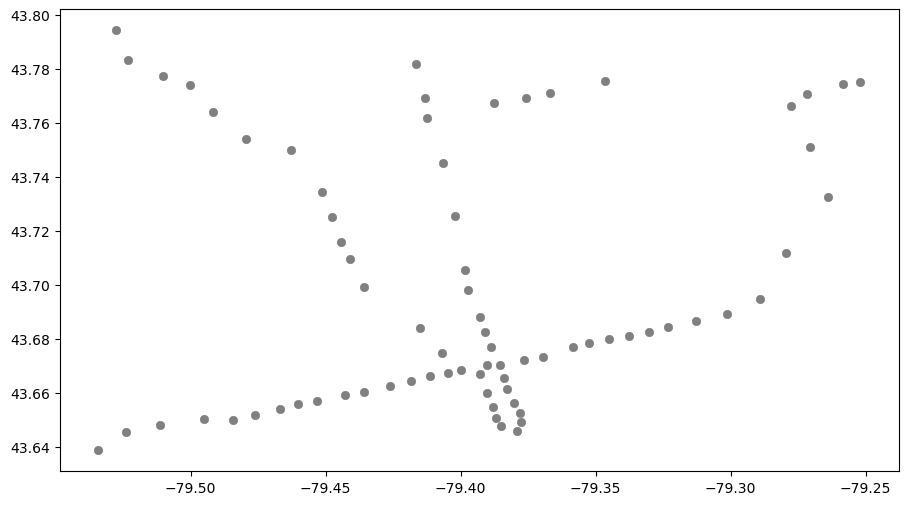

In [8]:
fig, ax = plt.subplots(figsize = (12,6))
ttc_map.plot(ax = ax,
             color = 'gray',
             linewidth = 0.5)
plt.show()

# Functions and Loops

We'll define some functions here that will speed up our EDA.

In [52]:
# create table summaries per delay cause, grouped per station
def station_cause(cause):
    grouped_cause = df_master[df_master['delay_cause'] == cause].groupby(df_master['station_clean']).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
    grouped_cause['average_delay'] = grouped_cause['delay_duration'] / grouped_cause['total_occurrence']
    grouped_cause_top_10 = grouped_cause.sort_values(by = ['delay_duration'], ascending = False).head(10)
    return grouped_cause_top_10

In [160]:
def create_map(cause, 
               title = None,
               color = None):
    # create table summary
    grouped_cause = df_master[df_master['delay_cause'] == cause].groupby(df_master['station_clean']).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
    # create map based on map data
    fig, ax = plt.subplots(figsize = (12,6))
    ttc_map.plot(ax = ax,
                 color = 'white',
                 linewidth = 0.1)
    # merge grouped table and map data
    merged_data = ttc_map.merge(grouped_cause, left_on = 'station_clean', right_on = 'station_clean', how = 'left')
    # create map based on merged data
    merged_data.plot(ax = ax, 
                    column = 'delay_duration', 
                    cmap = color, 
                    legend = True, 
                    markersize = merged_data['delay_duration'] / 10,
                    legend_kwds = {'label': "Total Delay Duration (Minutes)",
                                   'orientation': "vertical"})
    # Annotate the top 10 stations
    top_10_stations = merged_data.sort_values(by = ['delay_duration'], ascending = False).head(10)
    for index, row in top_10_stations.iterrows():
        ax.annotate(row['station_clean'], 
                    (row['geometry'].x, row['geometry'].y),
                    xytext = (row['geometry'].x + 0.005, row['geometry'].y + 0.0),
                    fontsize = 8, 
                    color = 'black')
    # Add labels and title
    plt.title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

In [11]:
# group per station, per delay cause and per month
def grouped_station(station):
    grouped_cause = df_master[df_master['station_clean'] == station].groupby([
        df_master['delay_cause'],
        df_master['datetime'].dt.to_period('M').dt.to_timestamp()]).agg(
            total_occurrence = ('Min Delay', 'count'),
            delay_duration = ('Min Delay', 'sum')).reset_index()
    grouped_cause['average_duration'] = grouped_cause['delay_duration'] / grouped_cause['total_occurrence']
    return grouped_cause

In [147]:
# create linear regression table
def linear_regression_table(station):
    grouped_cause = grouped_station(station)
    # create a new column to convert datetime column from datetime data type to numeric data type
    grouped_cause['datetime_numeric'] = grouped_cause['datetime'].apply(lambda x: x.timestamp())

    # perform linear regression
    results = []
    for cause in grouped_cause['delay_cause'].unique():
        subset = grouped_cause[grouped_cause['delay_cause'] == cause]
        if len(subset) < 2 or subset['datetime_numeric'].var() == 0 or subset['delay_duration'].var() == 0:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
        predicted_y = slope * subset['datetime_numeric'] + intercept
        significance = 'Y' if p_value < 0.05 else 'N'
        strong_significance = 'Y' if p_value < 0.01 else 'N'
    
        # create a table
        results.append({
            'delay_cause': cause,
            'slope': slope,
            'intercept': intercept,
            'r-value': r_value,
            'p-value': p_value,
            'std_err': std_err,
            'pval < 0.05': significance,
            'pval < 0.01': strong_significance})
    
    # create a dataframe from the list to enable sorting of values
    results = pd.DataFrame(results)
    results_10 = results[results['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False).head(10)
    return results_10

In [23]:
# plot linear regression
def linear_regression_plot(station):
    grouped_cause = grouped_station(station)
    # create a new column to convert datetime column from datetime data type to numeric data type
    grouped_cause['datetime_numeric'] = grouped_cause['datetime'].apply(lambda x: x.timestamp())

    # perform linear regression
    results = []
    plt.figure(figsize = (15,8))
    for cause in grouped_cause['delay_cause'].unique():
        subset = grouped_cause[grouped_cause['delay_cause'] == cause]
        if len(subset) < 2 or subset['datetime_numeric'].var() == 0 or subset['delay_duration'].var() == 0:
            continue
        slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
        predicted_y = slope * subset['datetime_numeric'] + intercept
        significance = 'Y' if p_value < 0.05 else 'N'
        strong_significance = 'Y' if p_value < 0.01 else 'N'
    
        # create a table
        results.append({
            'delay_cause': cause,
            'slope': slope,
            'intercept': intercept,
            'r-value': r_value,
            'p-value': p_value,
            'std_err': std_err,
            'pval < 0.05': significance,
            'pval < 0.01': strong_significance})
     
        # plot the regression line per delay cause
        plt.plot(subset['datetime_numeric'], 
            predicted_y, 
            label = f'{cause} - Regression Line', 
            linestyle = '--')

    # create a dataframe from the list to enable sorting of values
    results = pd.DataFrame(results)
    results_10 = results[results['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False).head(10)

    # annotate the top 10 delay causes in terms of slope (only label causes which are strongly statistically significant)
    for i, row in results_10.iterrows():
        subset = grouped_cause[grouped_cause['delay_cause'] == row['delay_cause']]
        max_x = subset['datetime_numeric'].max()
        max_y = row['slope'] * max_x + row['intercept']

        plt.annotate(f"{row['delay_cause']}",
            xy = (max_x, max_y), 
            xytext = (max_x + 10000000, max_y + 0),
            arrowprops = dict(arrowstyle = "->", color = 'black'),
            fontsize = 6)

    plt.xlabel('Date (Numeric)')
    plt.ylabel('Delay Duration (in Minutes)')
    plt.title(f'Linear Regression of Duration of Delay Causes in {station} Station')
    plt.grid(axis = 'y')
    plt.tight_layout()
    plt.show()

# Station Delay Duration and Occurrence

We'll create a summary table for delay occurrence and duration per station.

In [13]:
station = df_master.groupby('station_clean').agg(
    total_occurrence = ('Min Delay', 'count'),
    delay_duration = ('Min Delay', 'sum')).reset_index()
station

,station_clean,total_occurrence,delay_duration
0,Bathurst,2140,4377
1,Bay,1596,4253
2,Bayview,912,3200
3,Bessarion,532,1837
4,Bloor-Yonge,21332,28188
...,...,...,...
70,Wilson,5429,14621
71,Woodbine,2054,5169
72,York Mills,3105,8503
73,York University,477,1274


Then we'll merge it with the ttc_map data set.

In [14]:
merged_data = ttc_map.merge(station, left_on = 'station_clean', right_on = 'station_clean', how = 'left')

And we plot!

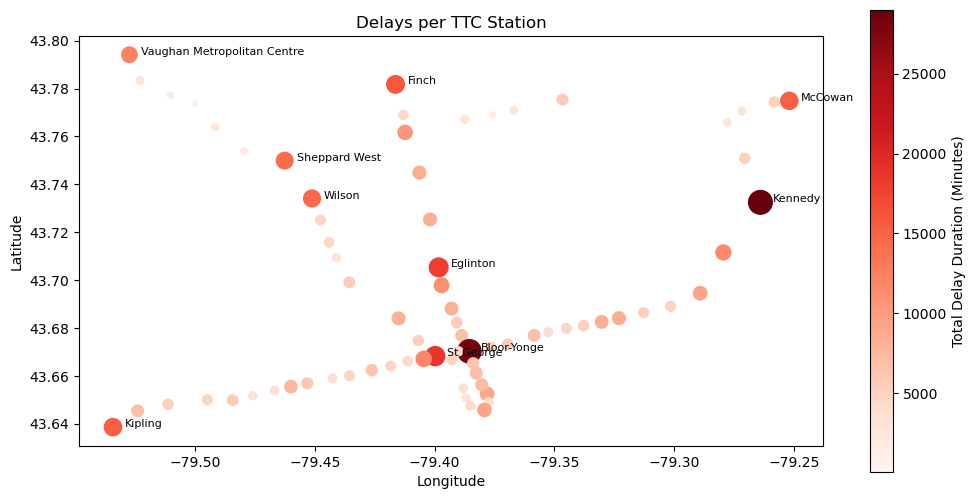

In [159]:
fig, ax = plt.subplots(figsize = (12, 6))
ttc_map.plot(ax = ax, 
             color = 'white', 
             linewidth = 0.5)
merged_data.plot(ax = ax, 
                 column = 'delay_duration', 
                 cmap = 'Reds', 
                 legend = True,
                 markersize = merged_data['delay_duration'] / 100,
                 legend_kwds={'label': "Total Delay Duration (Minutes)",
                              'orientation': "vertical"})
plt.title('Delays per TTC Station')

# Annotate the top 10 stations
top_10_stations = merged_data.sort_values(by = ['delay_duration'], ascending = False).head(10)
for index, row in top_10_stations.iterrows():
    ax.annotate(row['station_clean'], 
                (row['geometry'].x, 
                 row['geometry'].y),
                xytext = (row['geometry'].x + 0.005, row['geometry'].y + 0.0),
                fontsize = 8, 
                color = 'black')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [16]:
top_10_stations

,geometry,ADDRESS_POINT_ID,ADDRESS_NUMBER,LINEAR_NAME_FULL,ADDRESS_FULL,POSTAL_CODE,MUNICIPALITY,CITY,PLACE_NAME,GENERAL_USE_CODE,...,PT_TRANSF_REQ,PT_PUB_WASH,PT_PHONE,PT_OTHER_TRAN,PT_WEBSITE,PT_EXTRA1,PT_EXTRA2,station_clean,total_occurrence,delay_duration
66,POINT (-79.26399 43.73249),6674325.0,2455,Eglinton Ave E,2455 Eglinton Ave E,None,Scarborough,Toronto,None,115001.0,...,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Kennedy/stat...,None,None,Kennedy,10434,29009
5,POINT (-79.38554 43.67029),8535683.0,35,Bloor St E,35 Bloor St E,M4W 1A9,former Toronto,Toronto,None,115001.0,...,Yes,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Bloor-Yonge/...,None,None,Bloor-Yonge,21332,28188
9,POINT (-79.39981 43.66828),4030665.0,139,St George St,139 St George St,M5R 2L8,former Toronto,Toronto,None,115001.0,...,No,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/St_George/st...,None,None,St George,6677,18890
0,POINT (-79.39836 43.70535),11272589.0,2190,Yonge St,2190 Yonge St,M4S 2B8,former Toronto,Toronto,None,115001.0,...,"97,A,B,C,D Only",Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Eglinton/sta...,None,None,Eglinton,5978,17994
67,POINT (-79.41638 43.78176),7171768.0,5714,Yonge St,5714 Yonge St,None,North York,Toronto,None,115001.0,...,"97,B,C Only",Yes,(416) 393-4636,"GO Finch, York Region Transit, Brampton Transit",http://www.ttc.ca/Subway/Stations/Finch/statio...,None,None,Finch,8287,15944
34,POINT (-79.53437 43.63864),8353629.0,950,Kipling Ave,950 Kipling Ave,None,Etobicoke,Toronto,None,115001.0,...,No,Yes,(416) 393-4636,GO Kipling,http://www.ttc.ca/Subway/Stations/Kipling/stat...,None,None,Kipling,8285,15423
61,POINT (-79.25192 43.77487),6341040.0,1275,McCowan Rd,1275 McCowan Rd,None,Scarborough,Toronto,None,115001.0,...,Yes,No,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/McCowan/stat...,None,None,McCowan,2260,15238
32,POINT (-79.45124 43.73411),7994198.0,570,Wilson Ave,570 Wilson Ave,None,North York,Toronto,Wilson Subway Station,115001.0,...,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Wilson/stati...,None,None,Wilson,5429,14621
72,POINT (-79.46265 43.74993),10561028.0,1035,Sheppard Ave W,1035 Sheppard Ave W,None,North York,Toronto,Sheppard West Station,115001.0,...,No,Yes,(416) 393-4636,None,http://www.ttc.ca/Subway/Stations/Sheppard_Wes...,None,None,Sheppard West,4676,14287
73,POINT (-79.5275 43.79417),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vaughan Metropolitan Centre,4177,12356


### Findings: Station Delay Duration and Occurrence

1. The Top 10 stations with the longest total delay duration are: 
    a. Kennedy (29,009 mins), 
    b. Bloor-Yonge (28,188 mins), 
    c. St. George (18,890 mins), 
    d. Eglinton (17,994 mins), 
    e. Finch (15,944 mins), 
    f. Kipling (15,423 mins),
    g. McCowan (15,238 mins),
    h. Wilson (14,621 mins),
    i. Sheppard West (14,287 mins), and
    j. Vaughan Metropolitan Centre (12,356 mins).
2. Five (5) in the top 10 are stations that are the beginning/end of a subway line: Kipling, Kennedy, McCowan, Finch, and Vaughan Metropolitan Centre.
3. Two (2) in the top 10 are interchange stations between Line 1 and Line 2: Bloor-Yonge and St. George.
4. Eglinton Station is the fourth (4th) station with the longest total delay duration. Although it is not an interchange station nor is a beginning/ending station, Eglinton is one of the busiest stations in the TTC because of its location in Midtown Toronto. It also serves as a transit hub for multiple TTC bus routes. Additionally, the TTC has began the construction of another subway line, Line 5, with Eglinton Station serving as an interchange point.
5. Wilson Station is the eighth (8th) station with the longest total delay duration. Like Eglinton, it is not an interchange station nor is a beginning/ending station. It has a large bus terminal providing access to Yorkdale Mall and the Pearson Airport. It is close to Wilson Yard, one of TTC's main subway train storage and maintenance facilities.
6. Sheppard West Station is the ninth (9th) station with the longest total delay duration. Like Eglinton, it is not an interchange station nor is a beginning/ending station. It serves as an important bus hub in North York with connections to TTC bus routes and the York Region Transit. 


# Stations and Delay Causes

For this section of our EDA, the size of the bubbles and the deepness of the shade of color represents the total delay duration in minutes (i.e. the darker and bigger, the longer).

## Passenger Related Category

### Disorderly Patron

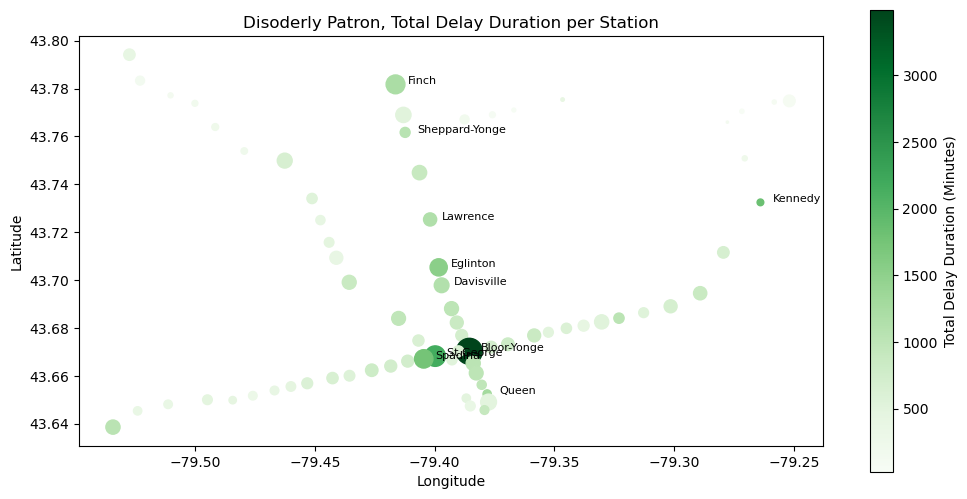

In [166]:
create_map('Disorderly Patron', 
           title = 'Disoderly Patron, Total Delay Duration per Station',
           color = 'Greens')

In [167]:
station_cause('Disorderly Patron')

,station_clean,total_occurrence,delay_duration,average_delay
4,Bloor-Yonge,1406,3491,2.482930
61,St George,664,2170,3.268072
31,Kennedy,542,1838,3.391144
57,Spadina,553,1750,3.164557
19,Eglinton,488,1533,3.141393
49,Queen,394,1297,3.291878
22,Finch,495,1205,2.434343
35,Lawrence,239,1151,4.815900
11,Davisville,290,1124,3.875862
55,Sheppard-Yonge,308,1063,3.451299


### Unauthorized at Track Level

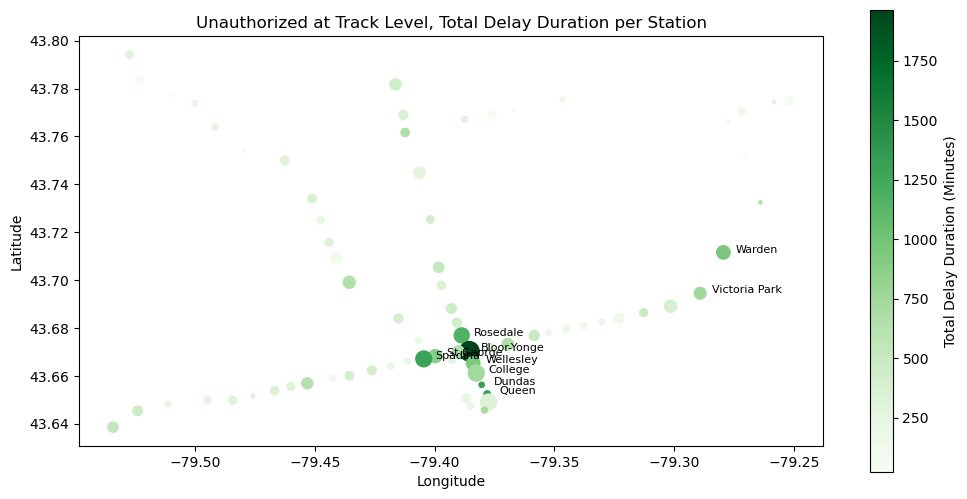

In [168]:
create_map('Unauthorized at Track Level', 
           title = 'Unauthorized at Track Level, Total Delay Duration per Station',
           color = 'Greens')

In [169]:
station_cause('Unauthorized at Track Level')

,station_clean,total_occurrence,delay_duration,average_delay
4,Bloor-Yonge,272,1964,7.220588
49,Queen,143,1333,9.321678
16,Dundas,187,1312,7.016043
57,Spadina,145,1288,8.882759
50,Rosedale,118,1165,9.872881
67,Warden,114,940,8.245614
68,Wellesley,117,939,8.025641
61,St George,126,883,7.007937
66,Victoria Park,87,754,8.666667
9,College,103,749,7.271845


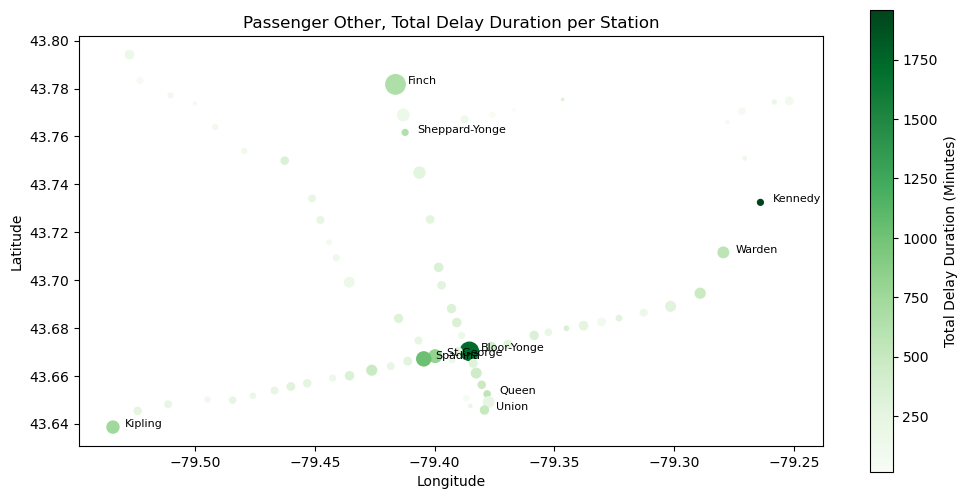

In [170]:
create_map('Passenger Other', 
           title = 'Passenger Other, Total Delay Duration per Station',
           color = 'Greens')

In [171]:
station_cause('Passenger Other')

,station_clean,total_occurrence,delay_duration,average_delay
31,Kennedy,331,1959,5.918429
4,Bloor-Yonge,776,1717,2.212629
57,Spadina,336,1020,3.035714
61,St George,297,814,2.740741
33,Kipling,203,745,3.669951
22,Finch,271,660,2.435424
55,Sheppard-Yonge,161,631,3.919255
67,Warden,171,577,3.374269
49,Queen,209,560,2.679426
64,Union,256,504,1.968750


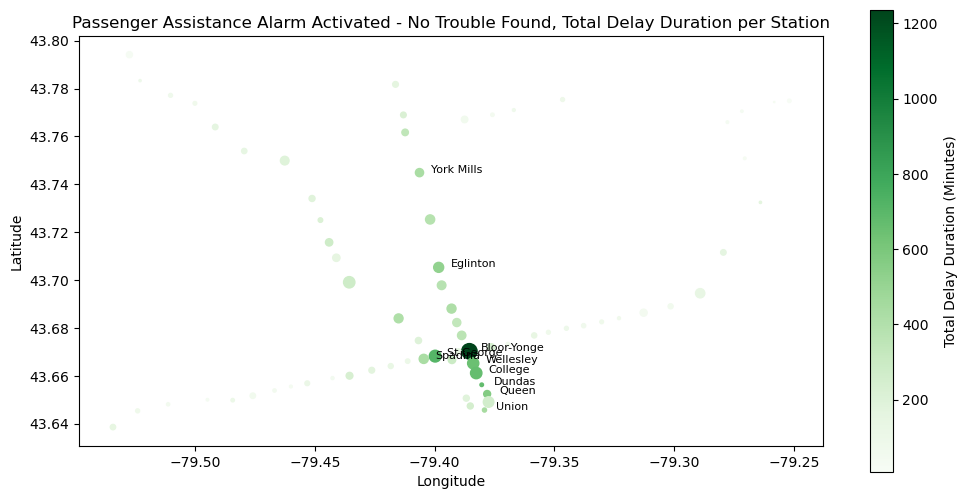

In [172]:
create_map('Passenger Assistance Alarm Activated - No Trouble Found', 
           title = 'Passenger Assistance Alarm Activated - No Trouble Found, Total Delay Duration per Station',
           color = 'Greens')

In [173]:
station_cause('Passenger Assistance Alarm Activated - No Trouble Found')

,station_clean,total_occurrence,delay_duration,average_delay
4,Bloor-Yonge,1015,1236,1.217734
61,St George,575,717,1.246957
16,Dundas,449,670,1.492205
9,College,466,667,1.431330
68,Wellesley,529,650,1.228733
49,Queen,465,574,1.234409
19,Eglinton,492,519,1.054878
64,Union,305,448,1.468852
71,York Mills,369,434,1.176152
57,Spadina,335,432,1.289552


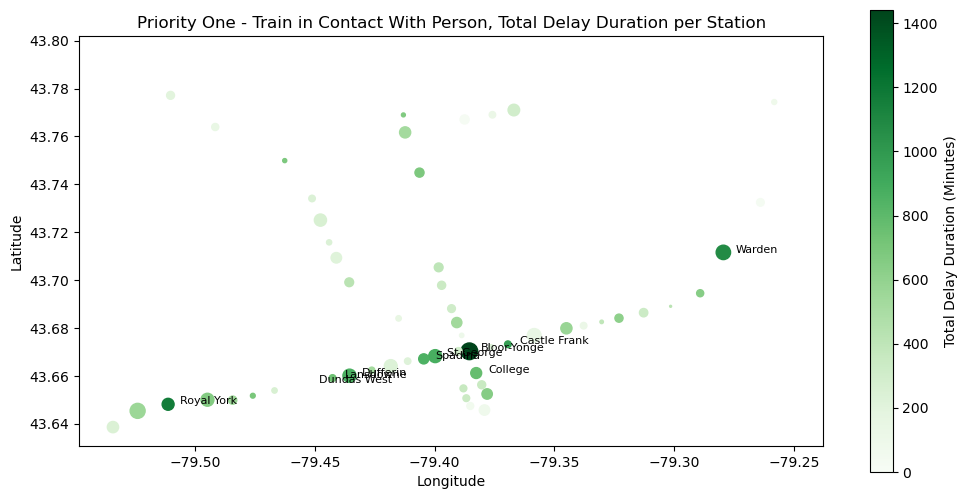

In [174]:
create_map('Priority One - Train in Contact With Person', 
           title = 'Priority One - Train in Contact With Person, Total Delay Duration per Station',
           color = 'Greens')

In [175]:
station_cause('Priority One - Train in Contact With Person')

,station_clean,total_occurrence,delay_duration,average_delay
4,Bloor-Yonge,24,1442,60.083333
43,Royal York,10,1166,116.600000
59,Warden,13,1076,82.769231
6,Castle Frank,12,980,81.666667
14,Dundas West,9,903,100.333333
53,St George,13,875,67.307692
12,Dufferin,9,868,96.444444
49,Spadina,13,859,66.076923
8,College,13,768,59.076923
30,Lansdowne,9,738,82.000000


## Equipment Related Category

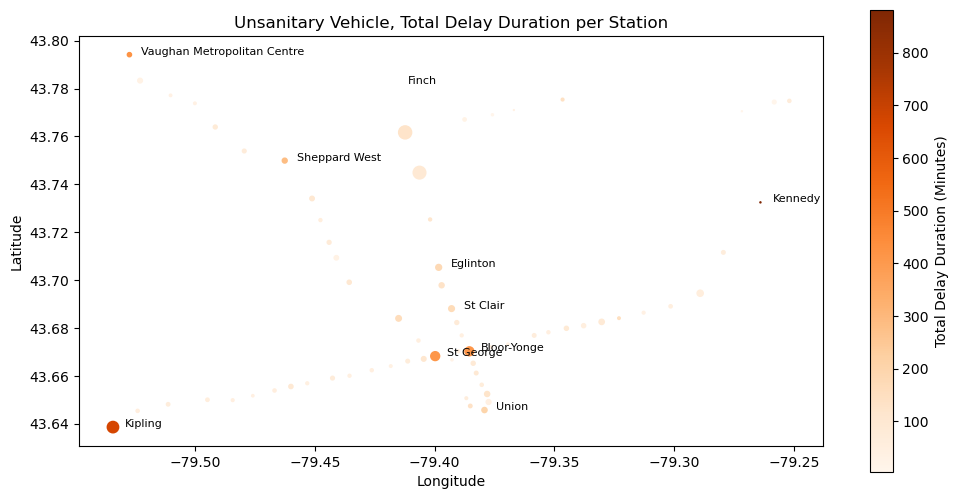

In [176]:
create_map('Unsanitary Vehicle', 
           title = 'Unsanitary Vehicle, Total Delay Duration per Station',
           color = 'Oranges')

In [177]:
station_cause('Unsanitary Vehicle')

,station_clean,total_occurrence,delay_duration,average_delay
30,Kennedy,230,881,3.830435
21,Finch,222,830,3.738739
32,Kipling,186,672,3.612903
63,Vaughan Metropolitan Centre,111,424,3.819820
4,Bloor-Yonge,90,412,4.577778
59,St George,83,410,4.939759
52,Sheppard West,66,285,4.318182
62,Union,42,200,4.761905
19,Eglinton,38,177,4.657895
57,St Clair,28,168,6.000000


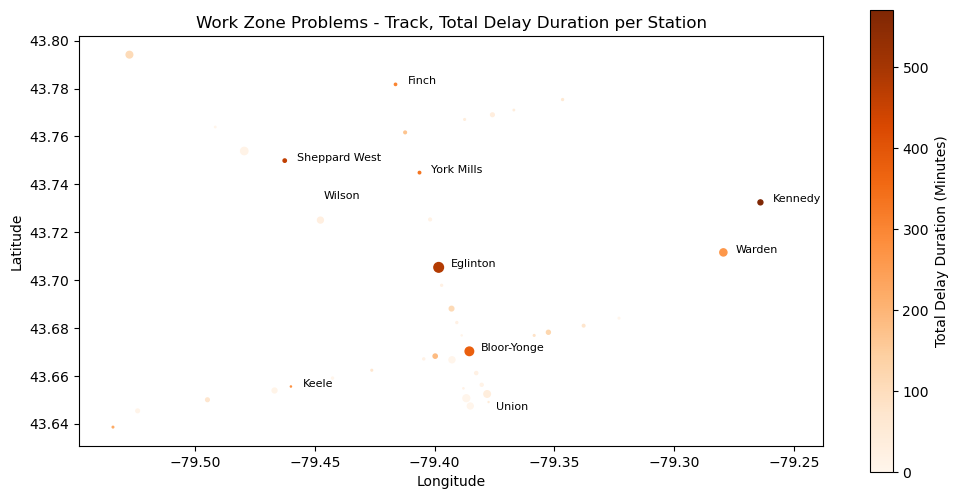

In [178]:
create_map('Work Zone Problems - Track', 
           title = 'Work Zone Problems - Track, Total Delay Duration per Station',
           color = 'Oranges')

In [179]:
station_cause('Work Zone Problems - Track')

,station_clean,total_occurrence,delay_duration,average_delay
24,Kennedy,34,571,16.794118
16,Eglinton,57,480,8.421053
40,Sheppard West,21,461,21.952381
2,Bloor-Yonge,38,378,9.947368
57,York Mills,38,334,8.789474
17,Finch,24,303,12.625000
23,Keele,28,278,9.928571
53,Warden,12,265,22.083333
55,Wilson,27,239,8.851852
50,Union,31,228,7.354839


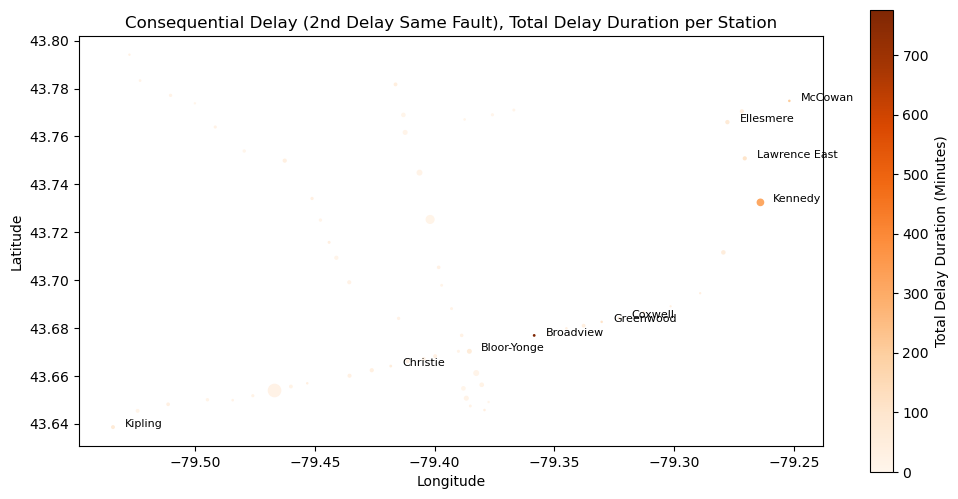

In [180]:
create_map('Consequential Delay (2nd Delay Same Fault)', 
           title = 'Consequential Delay (2nd Delay Same Fault), Total Delay Duration per Station',
           color = 'Oranges')

In [181]:
station_cause('Consequential Delay (2nd Delay Same Fault)')

,station_clean,total_occurrence,delay_duration,average_delay
5,Broadview,13,776,59.692308
29,Kennedy,67,308,4.597015
38,McCowan,33,205,6.212121
23,Greenwood,13,108,8.307692
34,Lawrence East,10,106,10.600000
31,Kipling,19,69,3.631579
19,Ellesmere,6,68,11.333333
4,Bloor-Yonge,15,63,4.200000
10,Coxwell,13,55,4.230769
8,Christie,11,53,4.818182


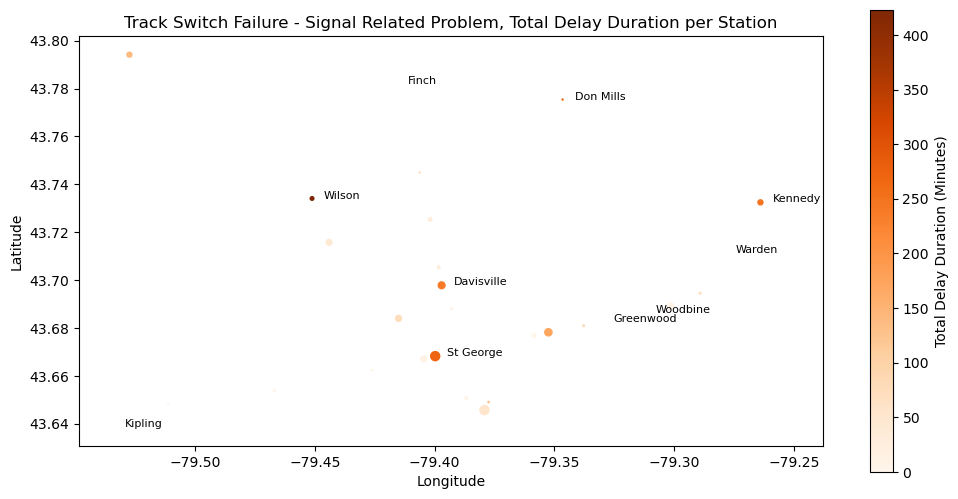

In [182]:
create_map('Track Switch Failure - Signal Related Problem', 
           title = 'Track Switch Failure - Signal Related Problem, Total Delay Duration per Station',
           color = 'Oranges')

In [183]:
station_cause('Track Switch Failure - Signal Related Problem')

,station_clean,total_occurrence,delay_duration,average_delay
39,Wilson,44,423,9.613636
38,Warden,21,423,20.142857
34,St George,16,272,17.000000
6,Don Mills,8,261,32.625000
18,Kennedy,16,248,15.500000
40,Woodbine,21,248,11.809524
5,Davisville,35,239,6.828571
20,Kipling,31,228,7.354839
11,Finch,14,218,15.571429
13,Greenwood,27,185,6.851852


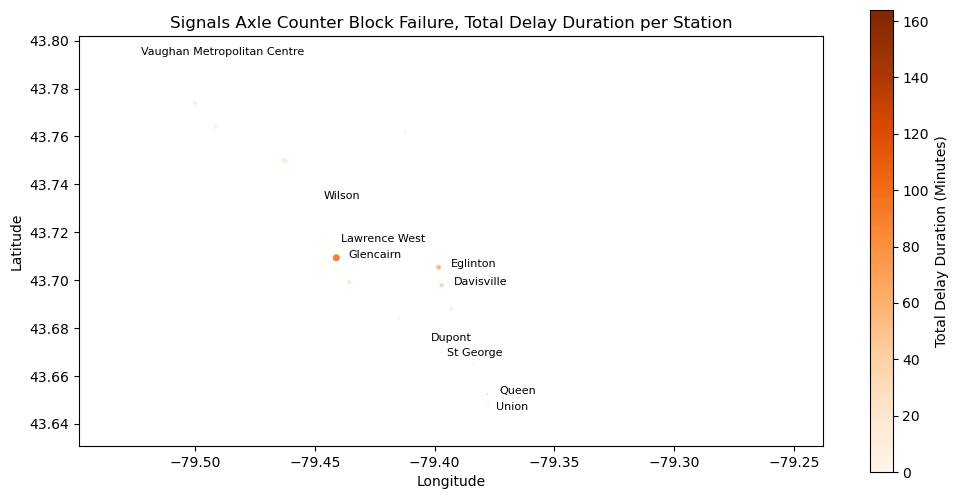

In [184]:
create_map('Signals Axle Counter Block Failure', 
           title = 'Signals Axle Counter Block Failure, Total Delay Duration per Station',
           color = 'Oranges')

In [185]:
station_cause('Signals Axle Counter Block Failure')

,station_clean,total_occurrence,delay_duration,average_delay
4,Dupont,35,164,4.685714
9,Glencairn,17,89,5.235294
30,Wilson,20,81,4.050000
27,Union,10,66,6.600000
25,St George,12,63,5.250000
5,Eglinton,7,55,7.857143
12,Lawrence West,8,48,6.000000
2,Davisville,7,39,5.571429
28,Vaughan Metropolitan Centre,3,31,10.333333
17,Queen,7,27,3.857143


## Personnel Related Category

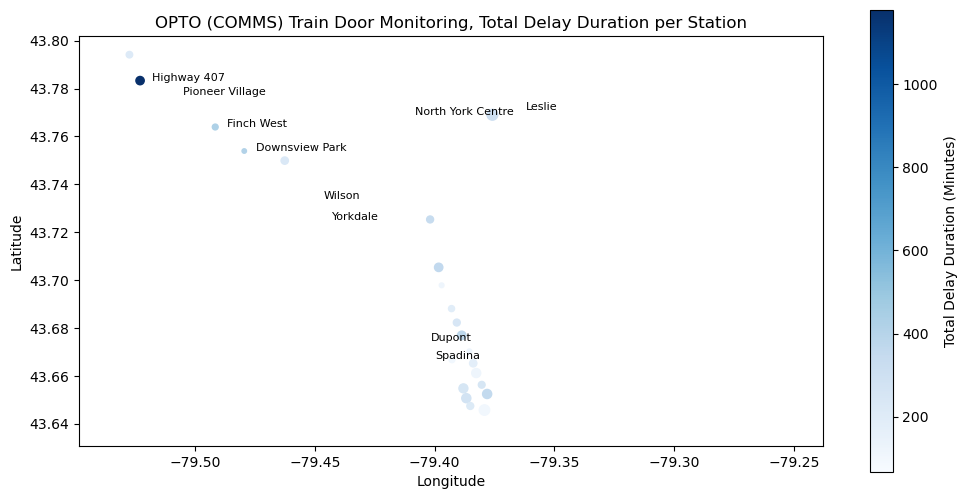

In [186]:
create_map('OPTO (COMMS) Train Door Monitoring', 
           title = 'OPTO (COMMS) Train Door Monitoring, Total Delay Duration per Station',
           color = 'Blues')

In [187]:
station_cause('OPTO (COMMS) Train Door Monitoring')

,station_clean,total_occurrence,delay_duration,average_delay
14,Highway 407,299,1179,3.943144
40,Yorkdale,226,930,4.115044
18,Leslie,130,648,4.984615
27,Spadina,146,607,4.157534
37,Wilson,194,562,2.896907
20,North York Centre,114,488,4.280702
12,Finch West,110,430,3.909091
22,Pioneer Village,129,430,3.333333
8,Dupont,94,423,4.500000
6,Downsview Park,117,416,3.555556


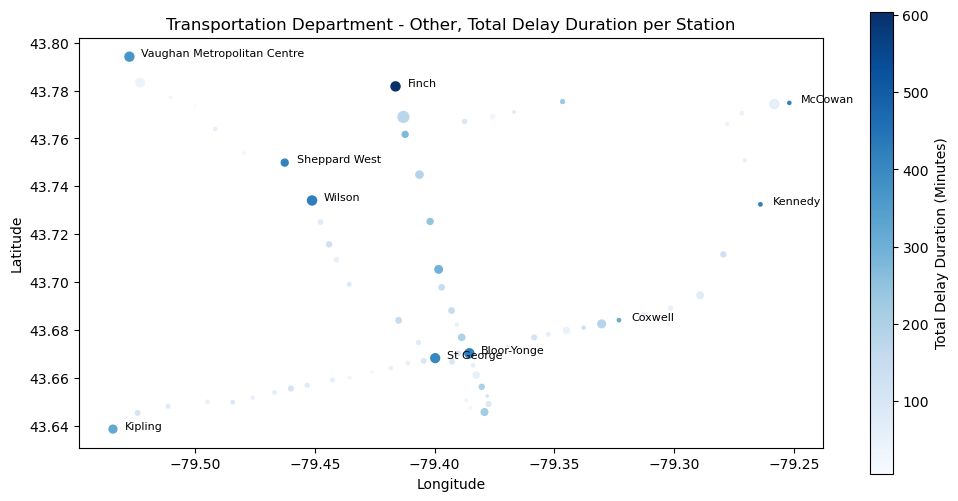

In [188]:
create_map('Transportation Department - Other', 
           title = 'Transportation Department - Other, Total Delay Duration per Station',
           color = 'Blues')

In [189]:
station_cause('Transportation Department - Other')

,station_clean,total_occurrence,delay_duration,average_delay
22,Finch,154,604,3.922078
31,Kennedy,124,424,3.419355
69,Wilson,101,424,4.198020
4,Bloor-Yonge,122,422,3.459016
40,McCowan,80,417,5.212500
54,Sheppard West,98,415,4.234694
61,St George,78,404,5.179487
65,Vaughan Metropolitan Centre,87,369,4.241379
33,Kipling,89,320,3.595506
10,Coxwell,65,308,4.738462


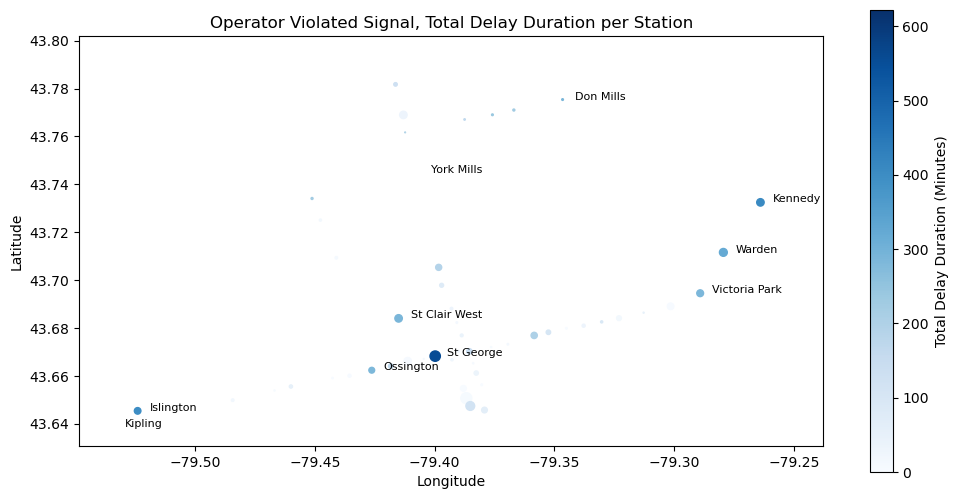

In [190]:
create_map('Operator Violated Signal', 
           title = 'Operator Violated Signal, Total Delay Duration per Station',
           color = 'Blues')

In [191]:
station_cause('Operator Violated Signal')

,station_clean,total_occurrence,delay_duration,average_delay
30,Kipling,255,622,2.439216
53,St George,184,555,3.016304
63,York Mills,157,439,2.796178
28,Kennedy,308,407,1.321429
25,Islington,214,399,1.864486
59,Warden,212,321,1.514151
12,Don Mills,171,288,1.684211
52,St Clair West,123,288,2.341463
58,Victoria Park,162,285,1.759259
40,Ossington,87,282,3.241379


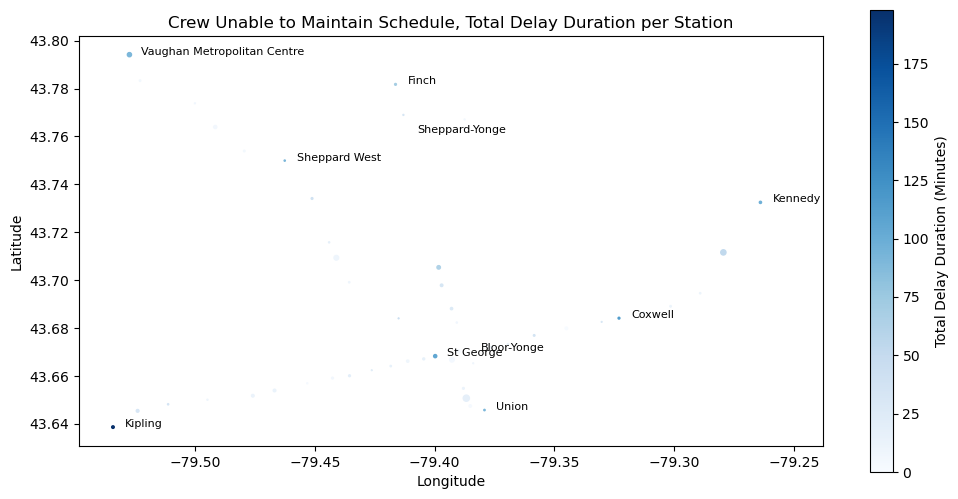

In [192]:
create_map('Crew Unable to Maintain Schedule', 
           title = 'Crew Unable to Maintain Schedule, Total Delay Duration per Station',
           color = 'Blues')

In [193]:
station_cause('Crew Unable to Maintain Schedule')

,station_clean,total_occurrence,delay_duration,average_delay
27,Kipling,37,198,5.351351
3,Bloor-Yonge,29,143,4.931034
7,Coxwell,24,114,4.750000
48,St George,20,105,5.250000
26,Kennedy,19,97,5.105263
41,Sheppard West,12,92,7.666667
52,Vaughan Metropolitan Centre,15,91,6.066667
51,Union,18,91,5.055556
42,Sheppard-Yonge,12,85,7.083333
17,Finch,10,70,7.000000


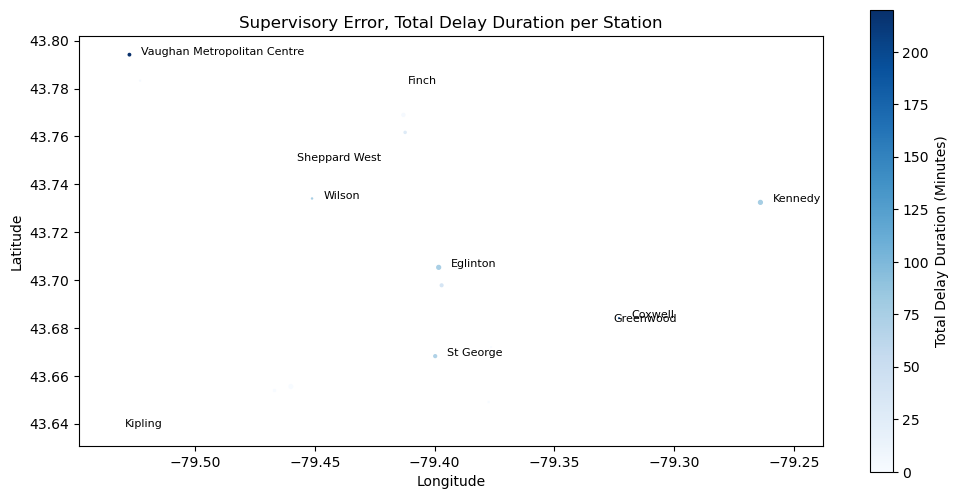

In [194]:
create_map('Supervisory Error', 
           title = 'Supervisory Error, Total Delay Duration per Station',
           color = 'Blues')

In [195]:
station_cause('Supervisory Error')

,station_clean,total_occurrence,delay_duration,average_delay
35,Vaughan Metropolitan Centre,37,220,5.945946
9,Finch,46,204,4.434783
3,Coxwell,41,204,4.975610
27,Sheppard West,25,138,5.520000
15,Kennedy,18,77,4.277778
10,Greenwood,12,75,6.250000
38,Wilson,18,75,4.166667
8,Eglinton,19,75,3.947368
32,St George,9,70,7.777778
17,Kipling,15,45,3.000000


# Stations

## Kennedy Station

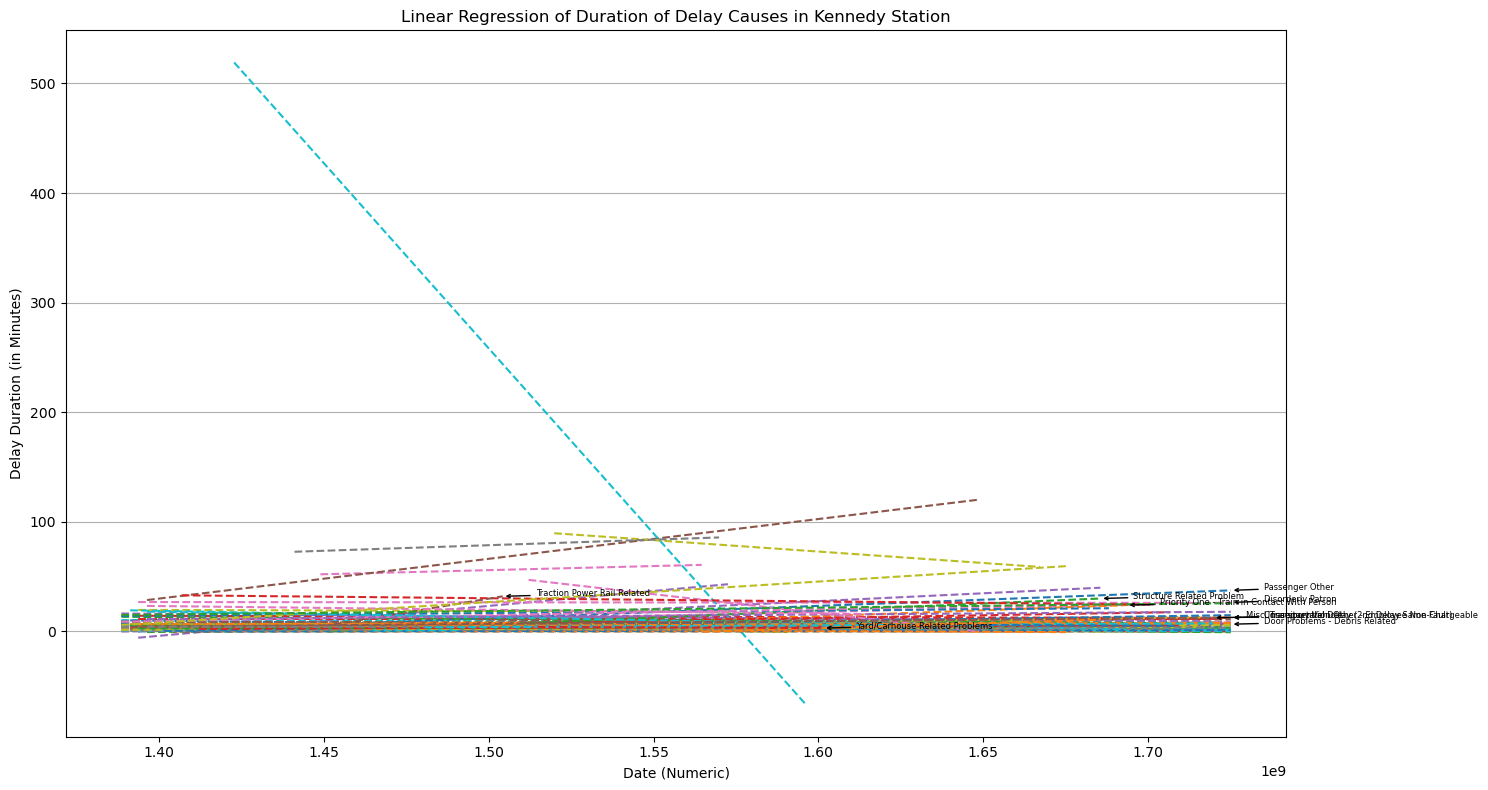

In [196]:
linear_regression_plot('Kennedy')

In [197]:
linear_regression_table('Kennedy')

,delay_cause,slope,intercept,r-value,p-value,std_err,pval < 0.05,pval < 0.01
85,Traction Power Rail Related,5.009674e-07,-721.567164,1.000000,0.000000,0.000000e+00,Y,Y
72,Structure Related Problem,1.282209e-07,-186.126292,1.000000,0.000000,0.000000e+00,Y,Y
50,Passenger Other,1.132415e-07,-157.919964,0.356057,0.000398,3.081825e-08,Y,Y
51,Priority One - Train in Contact With Person,1.086201e-07,-159.950991,1.000000,0.000000,0.000000e+00,Y,Y
16,Disorderly Patron,6.930124e-08,-93.156065,0.367296,0.000027,1.588827e-08,Y,Y
11,Consequential Delay (2nd Delay Same Fault),3.482460e-08,-47.412010,0.402964,0.008995,1.266516e-08,Y,Y
95,Unsanitary Vehicle,2.504291e-08,-30.720373,0.450266,0.000001,4.893244e-09,Y,Y
40,Misc. Transportation Other - Employee Non-Char...,2.241520e-08,-26.042355,0.315976,0.002280,7.134329e-09,Y,Y
18,Door Problems - Debris Related,1.089120e-08,-12.239778,0.338806,0.003601,3.614925e-09,Y,Y
103,Yard/Carhouse Related Problems,-1.152796e-08,21.462151,-1.000000,0.000000,0.000000e+00,Y,Y


## Bloor-Yonge Station

## St. George Station

## Eglinton Station

## Finch Station

## Kipling Station

## McCowan Station

## Sheppard West Station

## Vaughan Metropolitan Centre Station